In [ ]:

import os
import torch
import json
import jsonlines
import numpy as np
import seaborn as sns  
import random
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import matplotlib as mpl

mpl.rcParams['font.family'] = 'serif' 
mpl.rcParams['font.serif'] = ['Times New Roman']  
mpl.rcParams['font.size'] = 12

mpl.rcParams['text.color'] = 'black'

mpl.rcParams['font.weight'] = 'normal'
from scipy.stats import pearsonr

def get_shape(obj):
    """
    Recursively retrieve the shape of nested objects including tensors, lists, and tuples.
    """
    if isinstance(obj, torch.Tensor):
        return list(obj.shape)
    elif isinstance(obj, (list, tuple)):
        return [len(obj)] + get_shape(obj[0]) if len(obj) > 0 else []
    else:
        return []

def load_acd_scores(file_path,pt_name):
    acd_score_path = file_path+pt_name
    check_result_path = file_path+'/output_judge.jsonl'
    acd_scores = torch.load(acd_score_path)
    check_result = []
    with jsonlines.open(check_result_path) as reader:
        for obj in reader:
            check_result.append({'id': obj['id'], 'result': obj['result_type']})
    return acd_scores, check_result

def mean_of_2d_list(lst):
    flat_list = [item for sublist in lst for item in sublist]

    if not flat_list:
        return 0
    mean_value = sum(flat_list) / len(flat_list)
    return mean_value

def mean_of_layer(lst):
    layer_mean_value = []
    for layer in lst:
        layer_mean_value.append(sum(layer) / len(layer))
    return layer_mean_value


# 1 Stability of Layer-wise Features in the ICR Score

In [ ]:
def read_acd_scores(file_path, pt_name, sample_equal=False):
    acd_scores, check_result = load_acd_scores(file_path,pt_name)
    acd_scores_correct,acd_scores_wrong = [],[]

    for item in check_result:
        (key, value) = (item['id'], item['result'])
        if value == 1:
            acd_scores_correct.append(np.array(acd_scores[key]))
        elif value == 0:
            acd_scores_wrong.append(np.array(acd_scores[key]))
            
    # random samples to make the number of correct and wrong samples equal
    if sample_equal:
        n_samples = min(len(acd_scores_wrong), len(acd_scores_correct))
        acd_scores_correct = random.sample(acd_scores_correct,n_samples)
        acd_scores_wrong = random.sample(acd_scores_wrong,n_samples) # [item, layer, token]
    print('correct length:',len(acd_scores_correct), 'wrong length:',len(acd_scores_wrong))

    # [item, layer, token] -> [item, layer]
    layer_acd_correct = [np.mean(item,axis=-1) for item in acd_scores_correct] # [item, layer]
    layer_acd_wrong = [np.mean(item,axis=-1) for item in acd_scores_wrong]
 
    return layer_acd_correct, layer_acd_wrong 
def load_acd_scores(file_path,pt_name):
    acd_score_path = file_path+pt_name
    check_result_path = file_path+'/output_judge.jsonl'
    acd_scores = torch.load(acd_score_path)
    check_result = []
    with jsonlines.open(check_result_path) as reader:
        for obj in reader:
            check_result.append({'id': obj['id'], 'result': obj['result_type']})
    return acd_scores, check_result

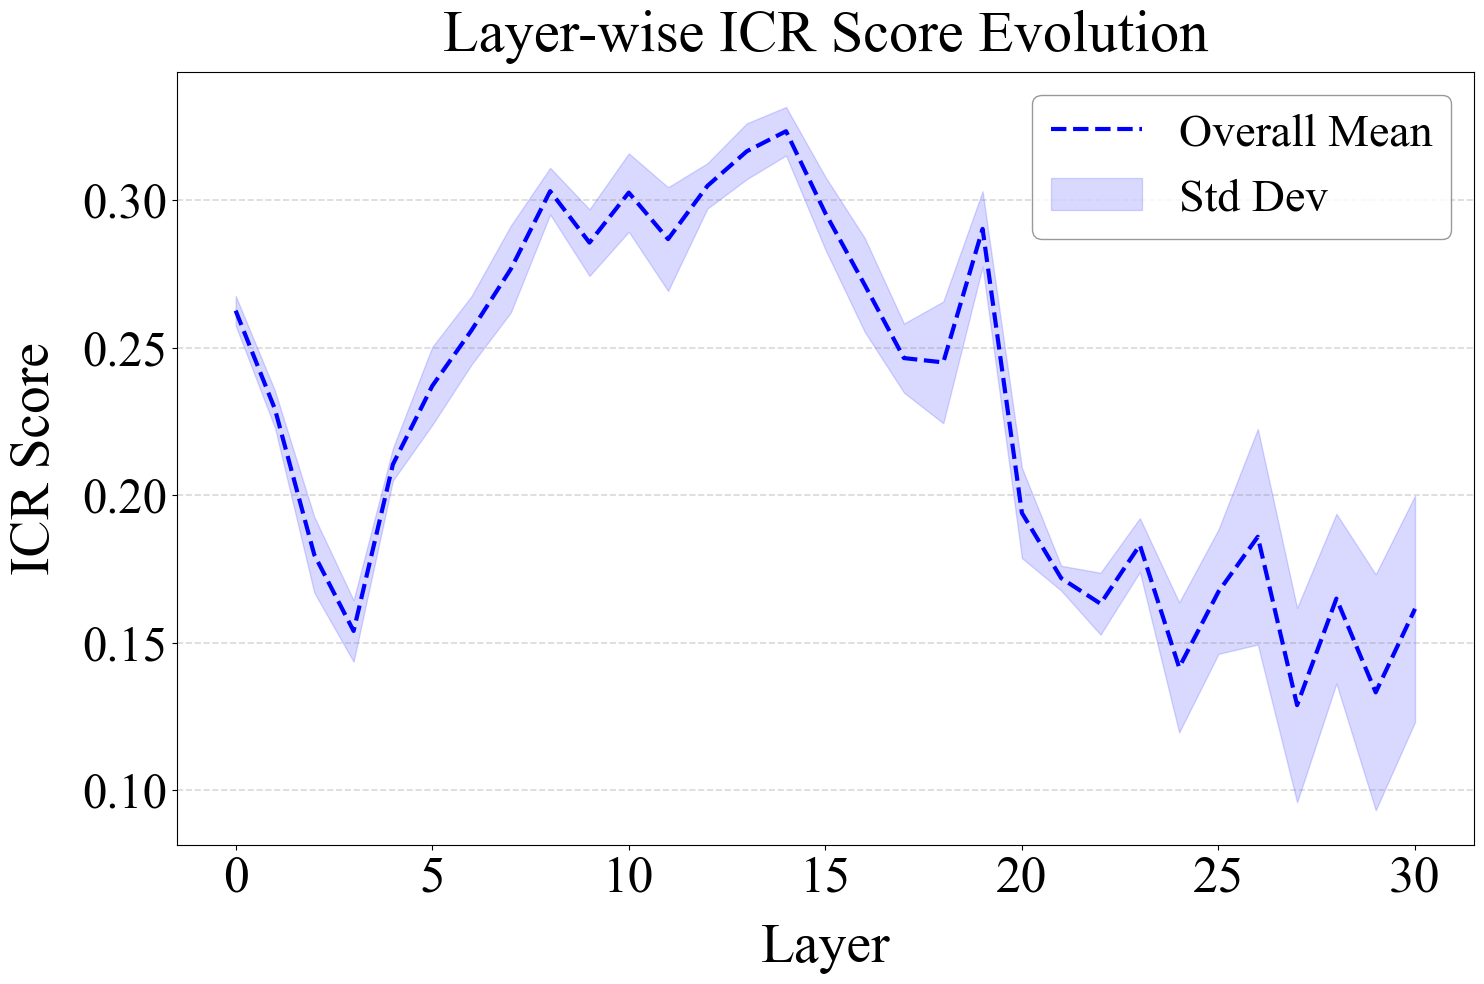

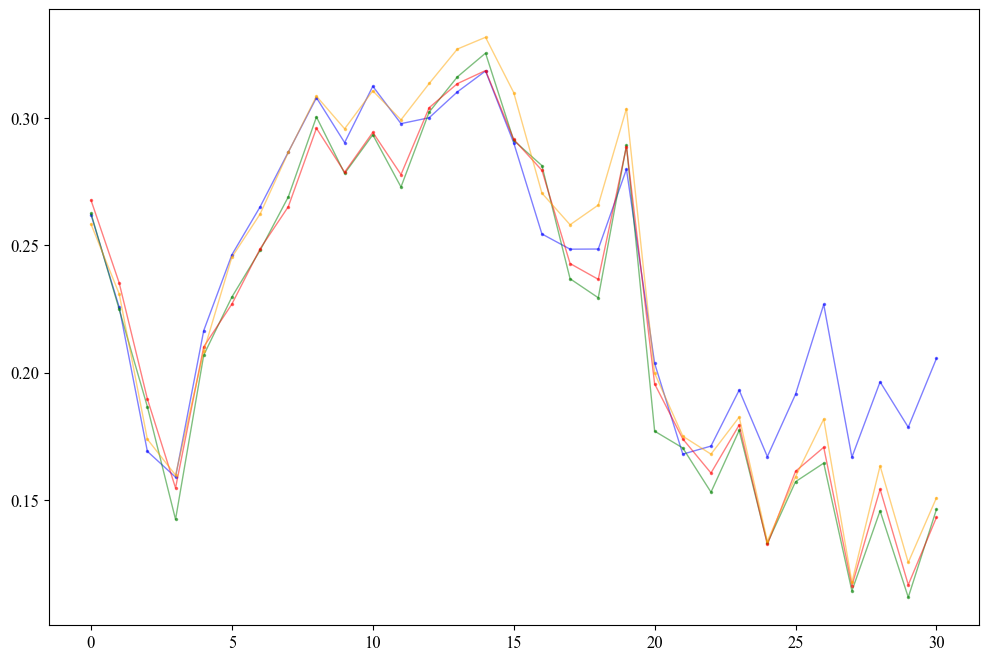

In [ ]:
def read_acd_scores_all(file_paths,pt_name):
    layer_acd = {}
    for dataset,file_path in file_paths.items():
        acd_scores, check_result = load_acd_scores(file_path,pt_name)
        layer_acd_scores = [np.mean(acd_scores[key],axis=-1) for key in acd_scores.keys()]
        layer_acd[dataset] = layer_acd_scores
    return layer_acd

def plot_acd_lineplot(layer_acd):
    plt.figure(figsize=(12, 8))
    all_curves = []  
    colors = ['blue', 'green', 'red', 'orange']
    linestyles = ['-', '-', '-', '-']
    markers = ['o', 'o', 'o', 'o']

    for idx, key in enumerate(layer_acd):
        mean_acd_scores = np.mean(layer_acd[key], axis=0)[:-1]
        x = np.arange(len(mean_acd_scores))
        plt.plot(x, mean_acd_scores,
                 label=key,
                 marker=markers[idx % len(markers)],
                 linestyle=linestyles[idx % len(linestyles)],
                 color=colors[idx % len(colors)],
                 linewidth=1,      
                 alpha=0.5,        
                    markersize=1.5)
        all_curves.append(mean_acd_scores)

def plot_acd_ribbon(layer_acd):
    fig, ax = plt.subplots(figsize=(15, 10))
    all_curves = []
    for key in layer_acd:
        mean_scores = np.mean(layer_acd[key], axis=0)[:-1]
        all_curves.append(mean_scores)
    all_curves = np.array(all_curves)
    overall_mean = np.mean(all_curves, axis=0)
    overall_std = np.std(all_curves, axis=0)

    x = np.arange(len(overall_mean))
    ax.grid(True, axis='y', linestyle='--', linewidth=1.2, color='gray', alpha=0.3)
    ax.grid(False, axis='x')
    ax.plot(x, overall_mean, label='Overall Mean', color='blue', linestyle='--', linewidth=3, alpha=1)
    ax.fill_between(x, overall_mean - overall_std*1.5, overall_mean + overall_std*1.5,
                    color='blue', alpha=0.15, label='Std Dev')
    
    ax.set_title("Layer-wise ICR Score Evolution", fontsize=42, pad=15)
    ax.set_xlabel("Layer", fontsize=40, labelpad=15) 
    ax.set_ylabel("ICR Score", fontsize=40, labelpad=15)
    
    plt.xticks(fontsize=37)
    plt.yticks(fontsize=35)

    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')

    leg = ax.legend(frameon=True, facecolor='white', edgecolor='gray', fontsize=33, loc='upper right')
    
    plt.tight_layout()
    plt.show()

model = 'llama3'
file_paths = {
    'trivia_qa': fr'saves\trivia_qa\{}_trivia_qa_rc.nocontext_train'.format(model),
    'squad': fr'saves\squad\{}_squad_train_KQA'.format(model),
    'hotpot': fr'saves\hotpot\{}_hotpot'.format(model),
    'halu_eval': fr'saves\halu_eval\{}_halu_eval_qa_KQA'.format(model)
}
pt_name = '\icr_score.pt'
layer_acd = read_acd_scores_all(file_paths, pt_name)


plot_acd_ribbon(layer_acd)
plot_acd_lineplot(layer_acd)

# 2 ICR Score’s Ability to Distinguish Hallucination

correct length: 8210 wrong length: 1605
Layer 0: AUROC = 0.5674
Layer 1: AUROC = 0.5794
Layer 2: AUROC = 0.6400
Layer 3: AUROC = 0.5258
Layer 4: AUROC = 0.6216
Layer 5: AUROC = 0.6916
Layer 6: AUROC = 0.7313
Layer 7: AUROC = 0.6955
Layer 8: AUROC = 0.7164
Layer 9: AUROC = 0.7256
Layer 10: AUROC = 0.6947
Layer 11: AUROC = 0.7690
Layer 12: AUROC = 0.7122
Layer 13: AUROC = 0.7475
Layer 14: AUROC = 0.7240
Layer 15: AUROC = 0.7135
Layer 16: AUROC = 0.7402
Layer 17: AUROC = 0.6854
Layer 18: AUROC = 0.6381
Layer 19: AUROC = 0.5172
Layer 20: AUROC = 0.5319
Layer 21: AUROC = 0.6089
Layer 22: AUROC = 0.5957
Layer 23: AUROC = 0.6310
Layer 24: AUROC = 0.6692
Layer 25: AUROC = 0.7042
Layer 26: AUROC = 0.6789
Layer 27: AUROC = 0.5792


<function matplotlib.pyplot.show(close=None, block=None)>

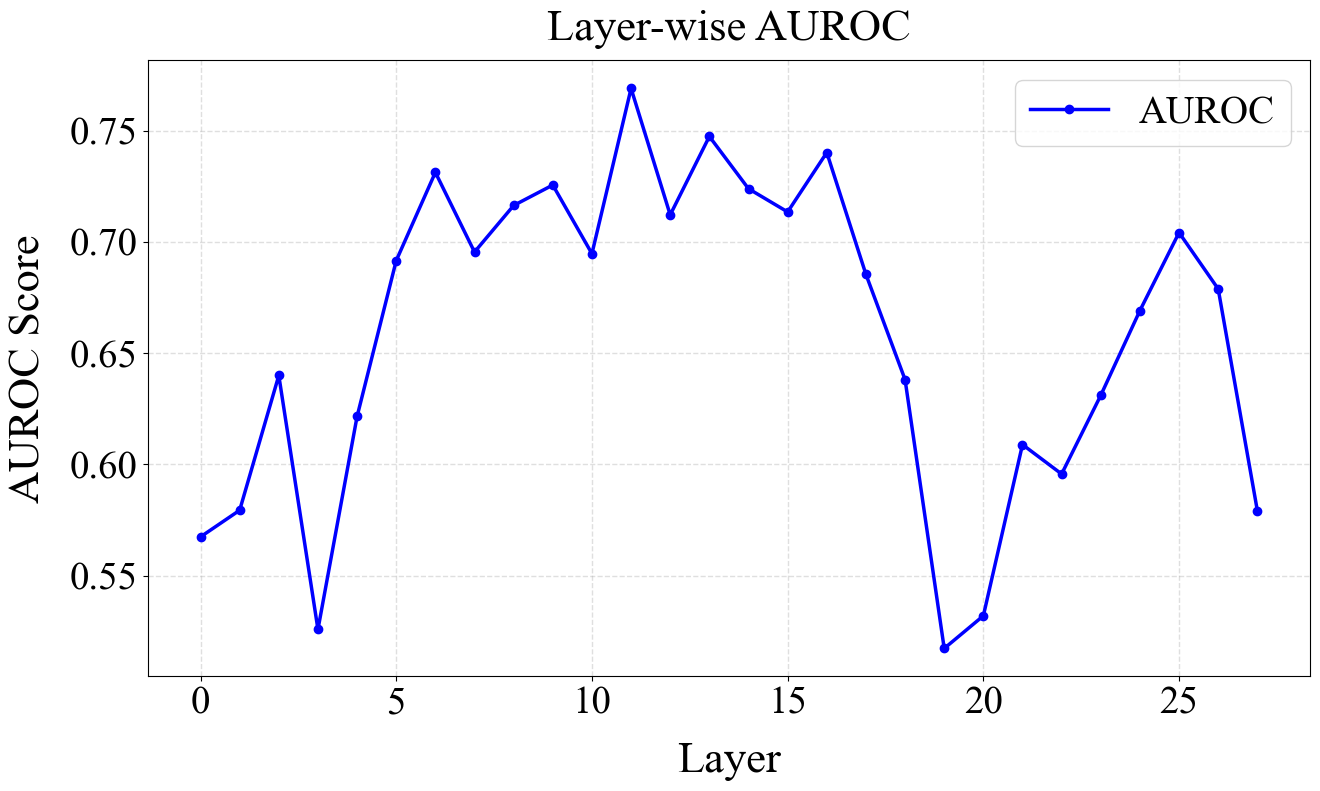

In [ ]:

model = 'qwen2.5'
file_path = fr'saves\halu_eval\{}_halu_eval_qa_KQA'.format(model) 
pt_name = '\icr_score.pt'
name = os.path.join(file_path,pt_name)
layer_acd_correct, layer_acd_wrong = read_acd_scores(file_path,pt_name,sample_equal=False)

layer_acd_correct = np.array(layer_acd_correct)
layer_acd_wrong = np.array(layer_acd_wrong)

num_layers = layer_acd_correct.shape[1]

auroc_scores = []
for layer in range(num_layers):
    y_true = np.concatenate([np.ones(len(layer_acd_correct)), np.zeros(len(layer_acd_wrong))])
    y_score = np.concatenate([layer_acd_correct[:, layer], layer_acd_wrong[:, layer]])
    auroc = roc_auc_score(y_true, y_score)
    auroc = max(auroc, 1 - auroc)  
    print(f"Layer {layer}: AUROC = {auroc:.4f}")
    auroc_scores.append(auroc)

plt.figure(figsize=(15, 8))
plt.plot(range(num_layers), auroc_scores, marker='o', linestyle='-', color='b', label='AUROC', linewidth=2.5)
plt.xlabel('Layer', fontsize=32, labelpad=15)
plt.ylabel('AUROC Score', fontsize=32, labelpad=15)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)

plt.title('Layer-wise AUROC', fontsize=32, pad=15)
plt.grid(True, linestyle='--', alpha=0.4,linewidth=1)
plt.legend(fontsize=28)
plt.show

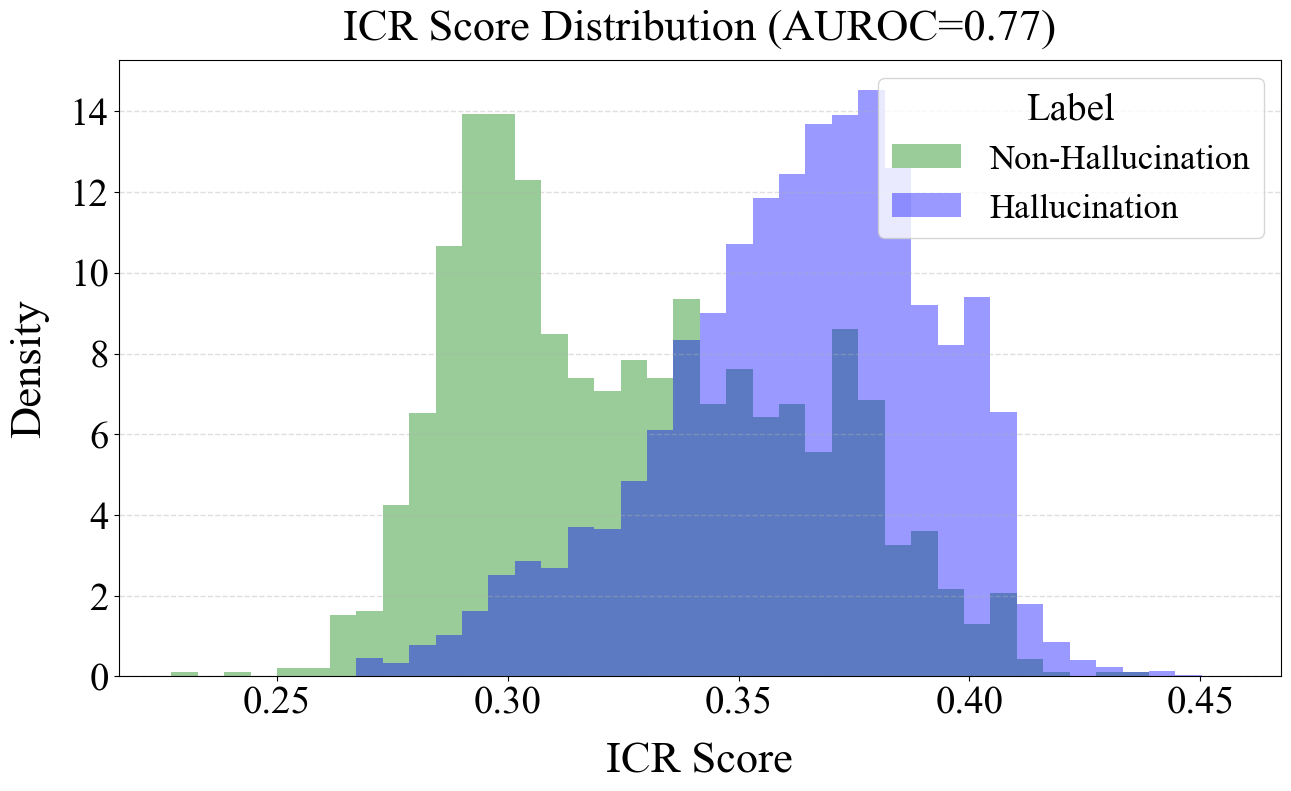

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

layer_index = 11 
val_labels = np.concatenate([np.ones(len(layer_acd_correct)), np.zeros(len(layer_acd_wrong))])
val_preds_continuous = np.concatenate([layer_acd_correct[:, layer_index], layer_acd_wrong[:, layer_index]])

data = pd.DataFrame({
    'ground truth': val_labels,
    'prediction': val_preds_continuous
})

data['label'] = data['ground truth'].map({0: 'Halu', 1: 'Correct'})
palette = {'Halu': 'green', 'Correct': 'blue'}  
plt.figure(figsize=(15, 8))
ax = sns.histplot(
    data=data,
    x='prediction',
    hue='label',
    bins=40,
    kde=False,
    stat="density",
    common_norm=False,

    palette=palette,
    alpha=0.4,
    edgecolor="none",  
    hue_order=['Correct', 'Halu'],  
)

title = f"ICR Score Distribution (AUROC=0.77)"
plt.title(title, fontsize=32,pad=15)  
plt.xlabel('ICR Score', fontsize=32, labelpad=15)
plt.ylabel('Density', fontsize=32, labelpad=15)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)

legend_elements = []
for label, color in palette.items():
    legend_elements.append(plt.Rectangle((0, 0), 1, 1, fc=color, ec='none', alpha=0.4))

ax.legend(
    handles=legend_elements,
    labels=['Non-Hallucination', 'Hallucination'],
    title='Label',
    title_fontsize=28,
    loc='upper right',
    fontsize=25
)

plt.grid(axis='y', linestyle='--', alpha=0.4, linewidth=1)
plt.show()